## CS 156a, HW2, Problems 5-10
### Author: Liting Xiao

This notebook:

- creates target functions of a line separating 2 classes {-1, 1}
- generates linearly seperable training/testing sets
- computes E_in and E_out for using **Linear Regression for classification**
- computes the number of iterations before **PLA**'s convergence with linear regression's input initial weights
- performs **non-linear transformation** and compares how much it improves over plain linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create target func f(x) = mx + b
# input space is [-1, 1] x [-1, 1]
def create_target_func():
    (x1, y1), (x2, y2) = np.random.uniform(-1, 1, (2, 2))
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

In [3]:
# defining point x_n above the line having y_n = 1
# while below the line having y_n = -1
def create_data_set(N, m, b):
    X = np.random.uniform(-1, 1, (2, N))
    Y = np.sign(X[1, :] - m * X[0, :] - b)
    return X, Y

In [4]:
# linear regression closed form solution
def linear_regression(X, Y):
    X = np.vstack((np.ones(X.shape[1]), X))
    X_dagger = np.linalg.pinv(X @ X.T) @ X
    return X_dagger @ Y

In [5]:
# evaluate in_sample or out_of_sample errors
def eval_err(w, X, Y):
    xcheck = np.vstack((np.ones(X.shape[1]), X))
    ycheck = np.sign(np.sum(w * xcheck.T, axis=1))
    return sum(Y != ycheck) / len(Y)

In [6]:
# PLA for training
def pla(w, X, Y):
    # shuffle the data set
    shuffle_idx = np.random.permutation(len(Y))
    X, Y = X[:, shuffle_idx], Y[shuffle_idx]
        
    # add x0 = 1 term
    xcheck = np.vstack((np.ones(X.shape[1]), X)).T
    ycheck = np.sign(np.sum(w * xcheck, axis=1))
        
    # train
    conv = 0
    while sum(Y != ycheck) != 0:
        mask = (Y != ycheck)
        idx = np.random.randint(sum(mask))
        x = xcheck[mask][idx]
        y = Y[mask][idx]
                    
        w += y * x
        ycheck = np.sign(np.sum(w * xcheck, axis=1))
        conv += 1

    return conv

**Problems 5-7**

In [7]:
N_ein, N_eout, N_pla = 100, 1000, 10
Ein, Eout, pla_conv = [], [], []
N_exp = 1000

for _ in range(N_exp):
    m_true, b_true = create_target_func()
    
    # linear regression and find in sample error
    X_ein, Y_ein = create_data_set(N_ein, m_true, b_true)
    init_w = linear_regression(X_ein, Y_ein)
    Ein.append(eval_err(init_w, X_ein, Y_ein))
    
    # find out of sample error
    X_eout, Y_eout = create_data_set(N_eout, m_true, b_true)
    Eout.append(eval_err(init_w, X_eout, Y_eout)) 
    
    # PLA
    X_pla, Y_pla = create_data_set(N_pla, m_true, b_true)
    pla_conv.append(pla(init_w, X_pla, Y_pla))
    
print('The average linear regression E_in: {:.3f}'.format(np.mean(Ein)))
print('The average linear regression E_out: {:.3f}'.format(np.mean(Eout)))
print('Average number of iterations for PLA to converge after linear regression '
      'for {} training points: {:.0f}'.format(N_pla, np.mean(pla_conv)))

The average linear regression E_in: 0.039
The average linear regression E_out: 0.048
Average number of iterations for PLA to converge after linear regression for 10 training points: 5


**Problem 8-10**

In [8]:
# target function: f(x1, x2) = sign(x1^2 + x2^2 − 0.6)
def create_data_set_nonlinear(N):
    X = np.random.uniform(-1, 1, (2, N))
    Y = np.sign(X[0, :] ** 2 + X[1, :] ** 2 - 0.6)
    # flip 10% of Y to add in noise
    idx = np.random.permutation(len(Y))[:int(0.1*N)]
    Y[idx] *= -1
    return X, Y

In [9]:
# use feature vector (1, x1, x2, x1 * x2, x1^2, x2^2)
def nonlinear_transformation(X):
    X_tr = np.vstack((X, X[0, :] * X[1, :]))
    X_tr = np.vstack((X_tr, X[0, :] ** 2))
    X_tr = np.vstack((X_tr, X[1, :] ** 2))
    return X_tr

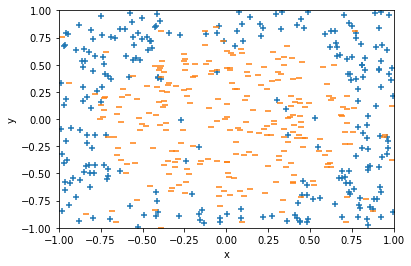

In [10]:
# visualize the non-linear dataset
X, Y = create_data_set_nonlinear(500)

plt.scatter(X[0, Y==1], X[1, Y==1], marker='+')
plt.scatter(X[0, Y==-1], X[1, Y==-1], marker='_')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
N_pt = 1000
Ein_no_tr, w_tr, Eout_test = [], [], []

for _ in range(N_exp):
    X, Y = create_data_set_nonlinear(N_pt)

    # linear regression without nonlinear transformation
    w_no_tr = linear_regression(X, Y)
    Ein_no_tr.append(eval_err(w_no_tr, X, Y))
    
    # nonlinear transformation to get new features
    X_tr = nonlinear_transformation(X)
    
    # linear regression with nonlinear transformation
    w_tr.append(linear_regression(X_tr, Y))
    
    # use a test set to get out of sample error
    X_test, Y_test = create_data_set_nonlinear(N_pt)
    X_test_tr = nonlinear_transformation(X_test)
    Eout_test.append(eval_err(w_tr[-1], X_test_tr, Y_test))
    
print('The average E_in without '
      'nonlinear transformation is {:.1f}\n'.format(np.mean(Ein_no_tr)))

best_w = np.mean(w_tr, axis=0)
print('The hypothesis found after nonlinear transformation is: \n'
      'g = sign({:.2f} + {:.2f}*x1 + {:.2f}*x2 + {:.2f}*x1*x2 + {:.2f}*x1^2 + {:.2f}*x2^2) \n'
      .format(best_w[0], best_w[1], best_w[2], best_w[3], best_w[4], best_w[5]))

print('The average E_out on test sets after '
      'nonlinear transformation is {:.1f}\n'.format(np.mean(Eout_test)))

The average E_in without nonlinear transformation is 0.5

The hypothesis found after nonlinear transformation is: 
g = sign(-0.99 + -0.00*x1 + 0.00*x2 + 0.00*x1*x2 + 1.56*x1^2 + 1.55*x2^2) 

The average E_out on test sets after nonlinear transformation is 0.1

